In [7]:
from Scripts.essentials import *
import h5py
from scipy.signal import savgol_filter
from scipy import stats
from sklearn.cluster import DBSCAN

In [8]:
ensemble_model = make_ensemble()
ensemble_model.load_weights(filepath= "Models/ensembleModelRes.h5")

standard_model = make_standard()
standard_model.load_weights(filepath = "Models/standardModel.h5")

cascade = tf.keras.models.load_model("Models/unet_three.23-64.96.h5")

import BartonModel
barton_model = BartonModel.load_model()
barton_model.summary()

img_path = "Figures/HF2600Denoising/"

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_unnormalized (InputLa  [(None, 600, 1, 1)]      0         
 yer)                                                            
                                                                 
 input_ (Normalization)      (None, 600, 1, 1)         1201      
                                                                 
 conv_1_ (Conv2D)            (None, 600, 1, 256)       2560      
                                                                 
 bnorm_1_ (BatchNormalizatio  (None, 600, 1, 256)      1024      
 n)                                                              
                                                                 
 re_lu_4 (ReLU)              (None, 600, 1, 256)       0         
                                                                 
 conv_2_ (Conv2D)            (None, 600, 1, 128)       1639

In [9]:
# Load the data into a dictionary
data_path = "Data/HF2600Sample/"

data = []
data_names = []
for sample in os.listdir(data_path):
    with h5py.File(data_path + sample) as f:
        regions = f["Regions"]
        
        datasets = []
        for region in list(regions):
            datasets.append(np.array(regions[region]["Dataset"]))
            
        data.append(datasets)
        data_names.append(sample)

In [10]:
# Define the Signal-to-Noise(SNR) ratio
def SNR(signal, noise, predicted_noise, eps = 0.0001):

    # SSNR from Han et al.
    s = np.mean(signal)
    n = np.std((noise - predicted_noise)) + eps # add eps if noise is 0
    return np.round((s)/(n), 1)

In [11]:
# Identify and remove non-tumor spectra as Lita et al.
def baseline_correction_and_silent_regions_removal(spectra):

    # Min-max normalize the data
    _min = np.expand_dims(np.min(spectra, axis = 1), -1)
    _max = np.expand_dims(np.max(spectra, axis = 1), -1)
    spectra_normalized = (spectra - _min)/(_max - _min)

    # Get the P-predictions from the standard model
    spectra = standard_model.predict(np.expand_dims(spectra_normalized, -1))[-1]
    
    # Remove silent regions from the P-vectors
    regions = [spectra[:, 104:907], spectra[:, 1374:]]

    # Concatenate and return non-silent region
    return np.concatenate(regions, axis = 1)


sample_shape = np.array(data[-1]).shape # Shape of sample
max_exposure = np.copy(np.array(data[-1])).reshape((-1, 1738)) # The sample taken with maximum exposure time
norm_data = baseline_correction_and_silent_regions_removal(max_exposure) # Preprocess the data with the method above
    
    
    # Renormalize the data to get a minimum of 0 and maximum of 1 in each spectrum (the P-vectors have an unclear maximum value as model output)
_min = np.expand_dims(np.min(norm_data, axis = 1), -1)
_max = np.expand_dims(np.max(norm_data, axis = 1), -1)
norm_data = (norm_data - _min) / (_max - _min)
    
    # Cluster the P-vectors to identify non-tumor and tumor spectra
clustering = DBSCAN(eps = 1.4, min_samples=1200).fit(norm_data)

200/200 [==============================] - 14s 71ms/step


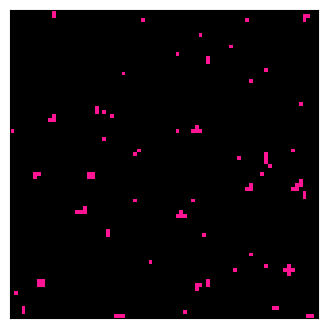

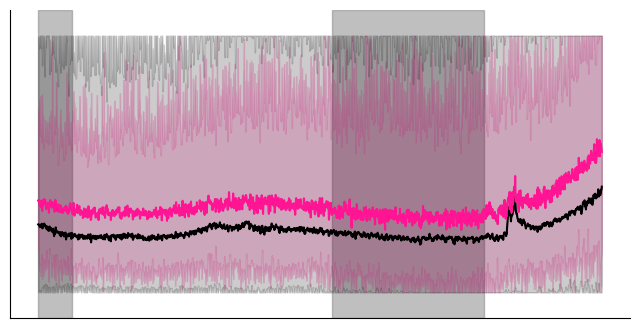

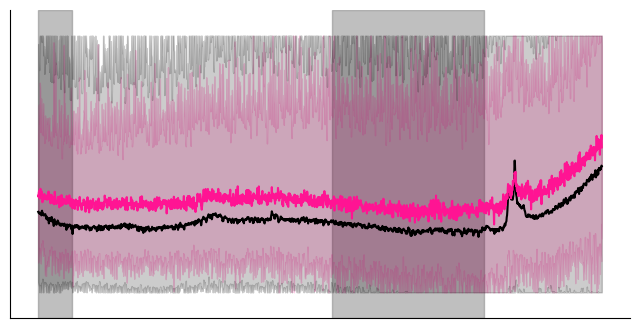

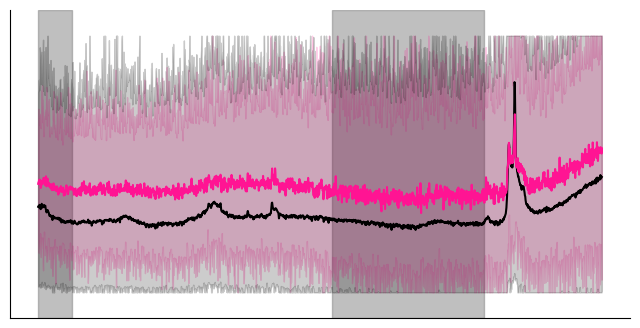

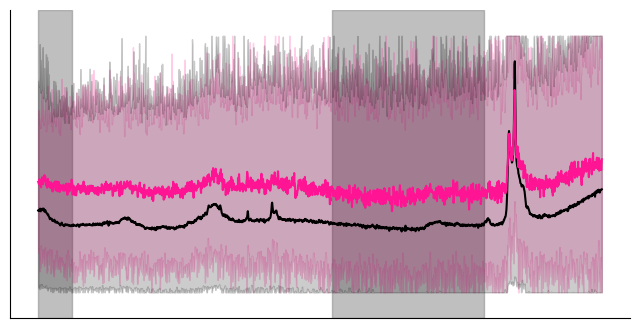

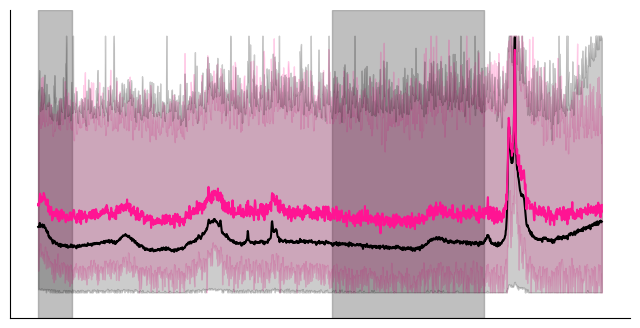

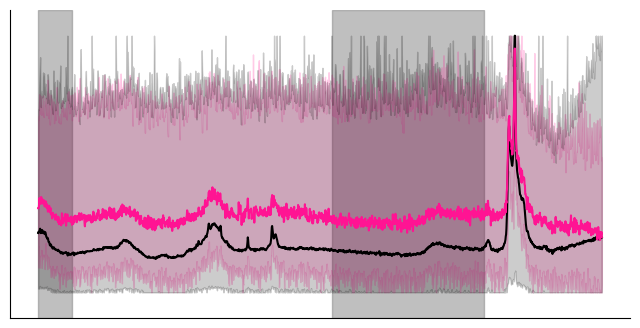

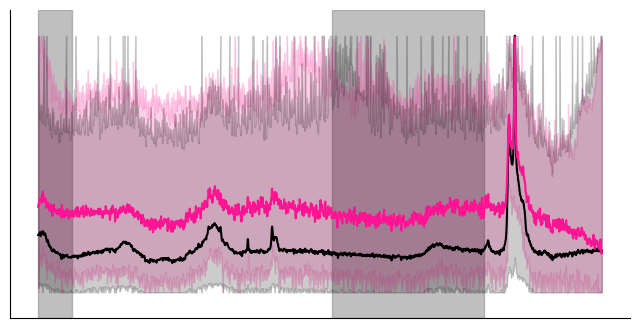

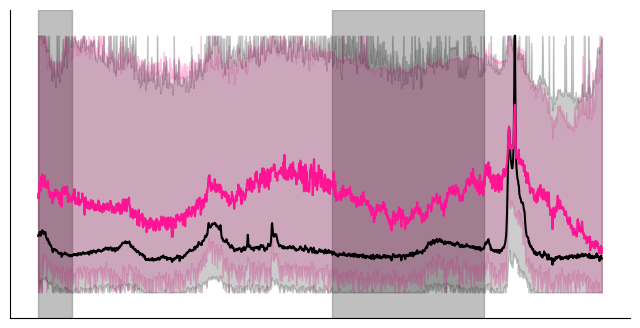

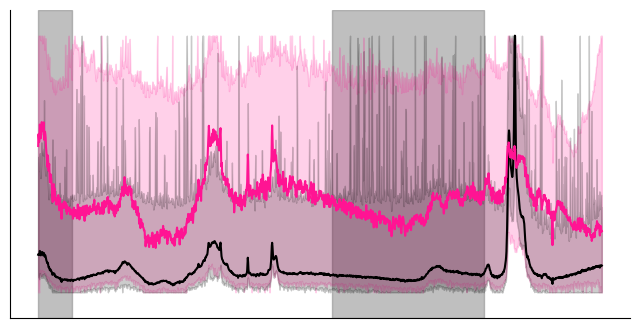

In [12]:
# We now return to the original data to remove spectra with the non-tumour label (and visualization)

plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"

import matplotlib.colors

# Color for False and True values
cmap = matplotlib.colors.ListedColormap(['deeppink', 'black'])

# Plot an image of the tumour map for the article
fig, ax = plt.subplots(figsize = (4, 4))
ax.imshow(np.array(clustering.labels_+1).reshape(sample_shape[1:-1]), cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(img_path + "tumor_nontumor_Map.pdf", format="pdf", dpi=1200)
plt.show()


for ix in range(len(data)):
    d = np.copy(data[ix]).reshape((-1, 1738))

    # min-max normalization
    maxim = np.max(d, axis = 1)
    minim = np.min(d, axis = 1)
    d = (d - np.expand_dims(minim, -1)) / np.expand_dims(maxim - minim, -1)

    tumour = np.copy(d[clustering.labels_ == 0])
    non_tumour = np.copy(d[clustering.labels_ != 0])
    
    fig, ax = plt.subplots(figsize = (8, 4))

    # Mark the silent regions to visualize the previous clustering step
    ax.axvspan(0, 103, color = "gray", alpha = 0.5)
    ax.axvspan(907, 1373, color = "gray", alpha = 0.5)

    ax.fill_between(np.arange(1738), np.percentile(non_tumour, 0, axis = 0), np.percentile(non_tumour, 100, axis = 0), alpha = 0.2, color = "deeppink")
    ax.fill_between(np.arange(1738), np.percentile(tumour, 0, axis = 0), np.percentile(tumour, 100, axis = 0), alpha = 0.2, color = "Black")

    # Display the mean spectra from each cluster 
    ax.plot(np.median(tumour, axis = 0), color = "Black")
    ax.plot(np.median(non_tumour, axis = 0), color = "deeppink")
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(-0.1, 1.1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig(img_path + "tumor_nontumor_distribution.pdf", format="pdf", dpi=1200, bbox_inches = "tight")
    plt.show()


    data[ix] = tumour # Remove the non-tumour spectra

In [13]:
# Locate peaks and appropriate noise regions
signal_regions = [   
                     np.array(range(450, 601)),
                     np.array(range(1430, 1531))
                     ]
    
noise_regions = [
                np.array(range(90, 191)),
                np.array(range(820, 921)),
                np.array(range(1070, 1171)),
                np.array(range(1630, 1731))
                ]

# Join the region indices into one list and keep an indicator for noise and signal regions
joined_regions = []
noise_signal_indicator = []
i, j = 0, 0

while i < len(noise_regions) or j < len(signal_regions):
    # Append the signal region
    if j == len(signal_regions):
        joined_regions.append(noise_regions[i])
        i += 1
        noise_signal_indicator.append(0)

    elif i == len(noise_regions):
        joined_regions.append(signal_regions[j])
        j += 1
        noise_signal_indicator.append(1)
        
    elif (noise_regions[i][0] < signal_regions[j][0]) :
        joined_regions.append(noise_regions[i])
        i += 1
        noise_signal_indicator.append(0)
    else:
        joined_regions.append(signal_regions[j])
        j += 1
        noise_signal_indicator.append(1)

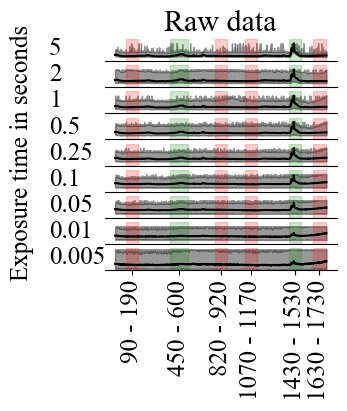

In [14]:
y_labels = []
for y in  data_names:
    y_labels.append(y[9: y.index("s")])


plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"

fig, axs = plt.subplots(len(data_names), figsize = (3, 3), sharex=False, sharey=False)
fig.text(-0.15, 0.5, 'Exposure time in seconds', ha='center', va='center', rotation='vertical')
axs[0].set_title("Raw data")

for en, n in enumerate(np.flip(data_names)):
    dn = np.squeeze(np.copy(data[-(en+1)]))
    noises = []
    # Get the noise and signal regions to count the SNR
    # Plot the percentiles on each frequency
    axs[en].fill_between(np.arange(1738), np.percentile(dn, 0, axis = 0), np.percentile(dn, 100, axis = 0), alpha = 0.4, color = "Black")

    # Plot the mean vector of the data class
    axs[en].plot(np.median(dn, axis = 0), color = "Black")

    for region in noise_regions:
        axs[en].axvspan(region[0], region[-1], color = "red", alpha = 0.2)

    for region in signal_regions:
        axs[en].axvspan(region[0], region[-1], color = "green", alpha = 0.2)

    

    axs[en].set_ylabel(np.flip(y_labels)[en], rotation=0, loc='bottom', labelpad=40)
    axs[en].set_xticks([])
    axs[en].set_yticks([])
    axs[en].set_ylim(-0.3, 1.3)
    axs[en].spines['left'].set_visible(False)
    axs[en].spines['right'].set_visible(False)
    axs[en].spines['top'].set_visible(False)

    
plt.autoscale() 
x_ticks = np.ravel([np.mean([np.min(reg), np.max(reg)]) for reg in joined_regions])
x_labels = [str(np.min(reg)) + " - " + str(np.max(reg)) for reg in joined_regions]
plt.xticks(x_ticks, x_labels, rotation = 90)
plt.savefig(img_path + "RawDataDistro.pdf", format="pdf", dpi=1200, bbox_inches = "tight")
plt.show()

HF2600exp5s.h5


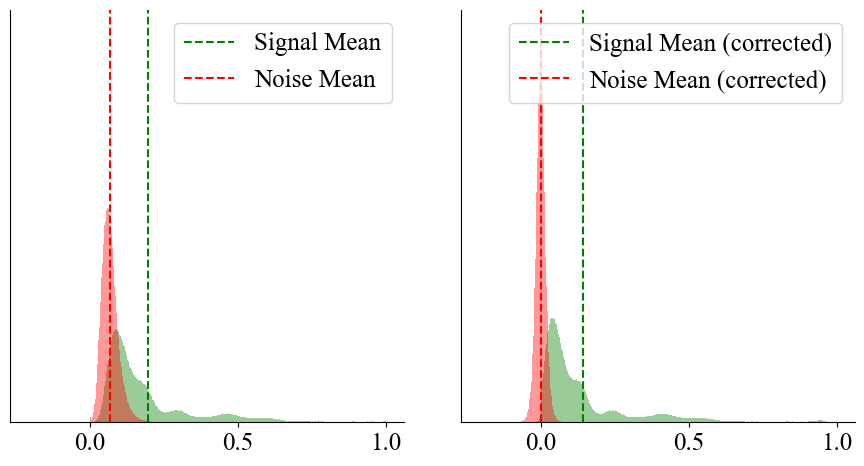

HF2600exp2s.h5


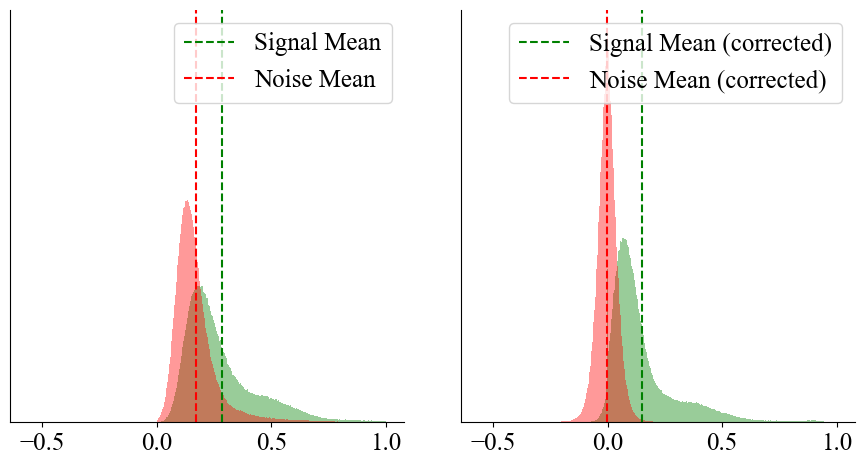

HF2600exp1s25um.h5


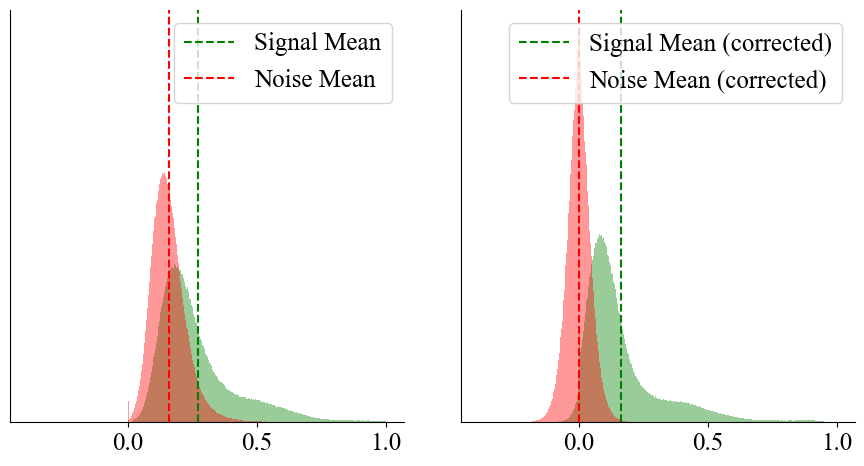

HF2600exp0.5s25um.h5


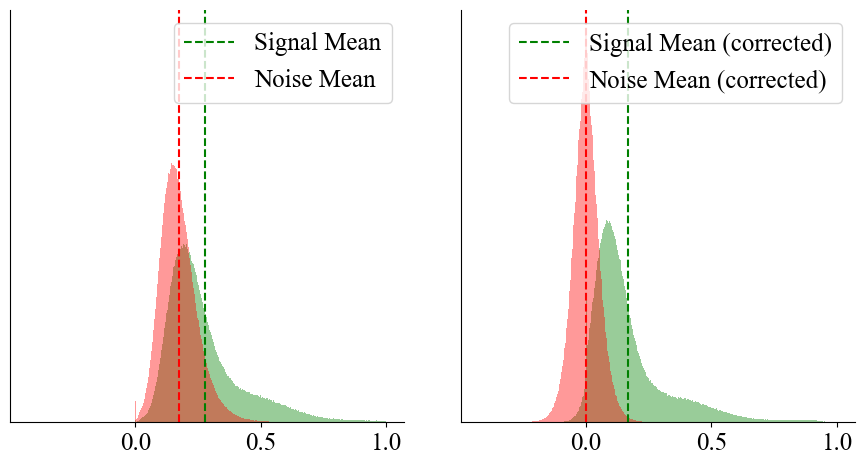

HF2600exp0.25s25um.h5


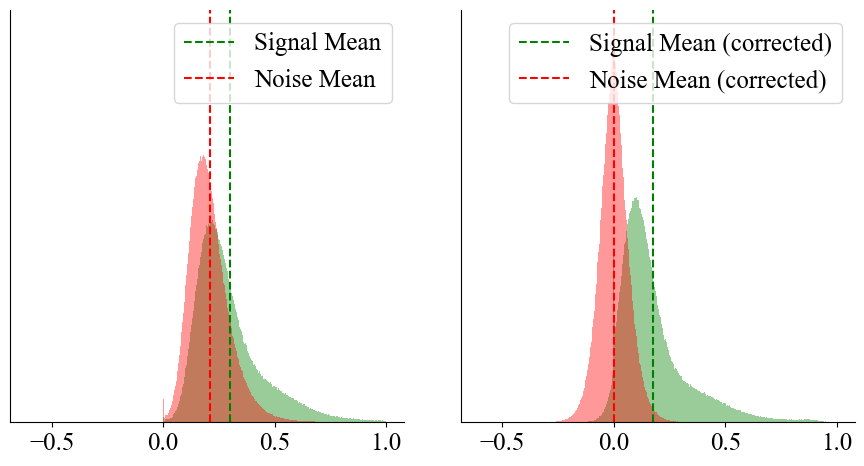

HF2600exp0.1s25um.h5


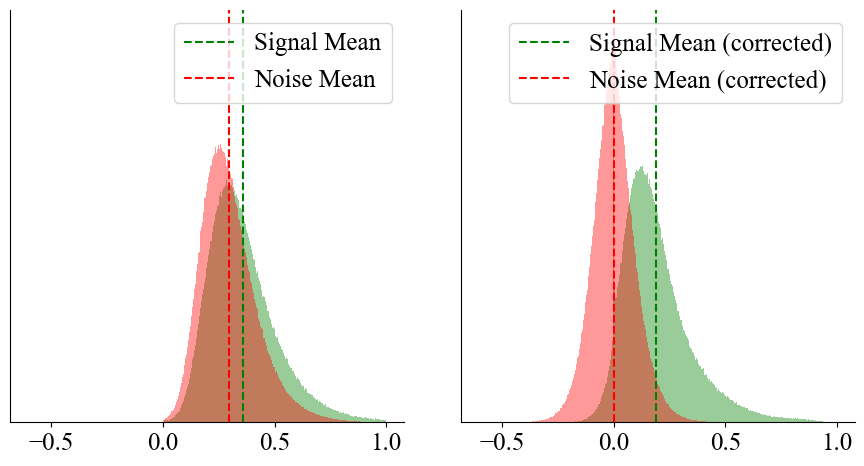

HF2600exp0.05s25um.h5


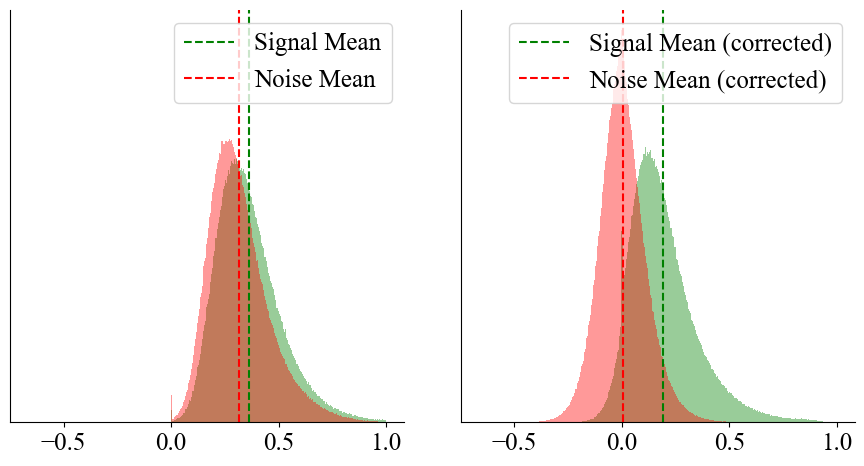

HF2600exp0.01s25um.h5


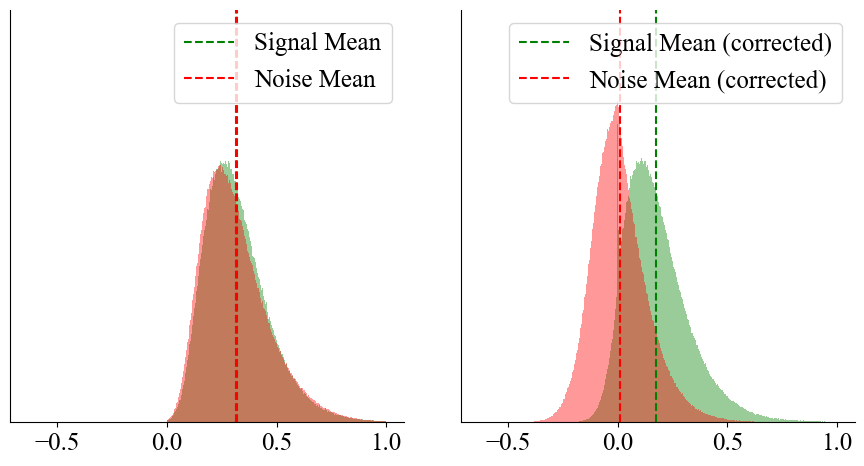

HF2600exp0.005s25um.h5


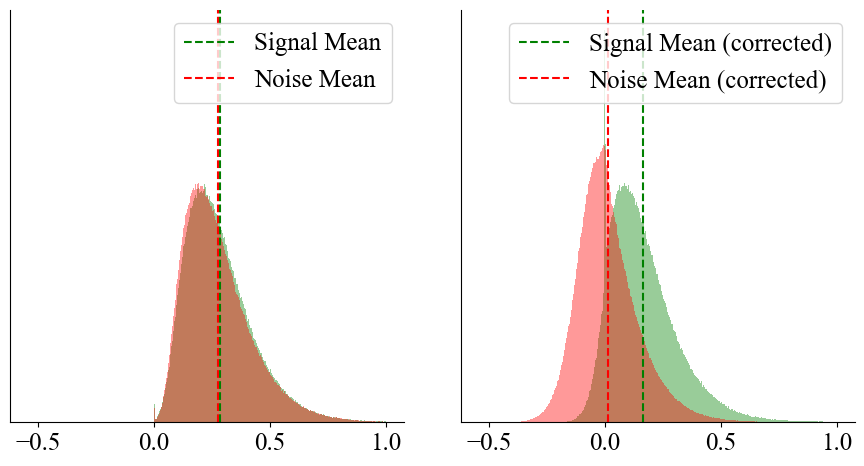

In [15]:
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"
mean_color = "orangered"
final_p_values = []


for en, n in enumerate(np.flip(data_names)):
    spec = np.squeeze(np.copy(data[-(en+1)])).reshape((-1, 1738))
    fixed = []
    noise_fixed = []
    noise_original = []
    signal_fixed = []
    signal_original = []
    print(n)
    
    for reg, indicator in zip(joined_regions, noise_signal_indicator):
        s = spec[:, reg]
        p_vals = []
        if indicator == 0:
            
            line = np.linspace(np.median(spec[:, reg[:8]], axis = 1), np.median(spec[:, reg[-8:]], axis = 1), len(reg))
            
            noise_original.append(s)
            noise = s - line.T# - np.expand_dims(mean, -1)
            fixed.append(noise)
            noise_fixed.append(noise)

        else:
            signal_original.append(s)
            
            line = np.linspace(np.min(spec[:, reg[:8]], axis = 1), np.min(spec[:, reg[-8:]], axis = 1), len(reg))
            signal = (s - line.T)
            signal_fixed.append(signal)
            
            fixed.append(signal)

    
    noise_fixed = np.concatenate(noise_fixed, axis = 1)
    noise_original = np.concatenate(noise_original, axis = 1)
    signal_fixed = np.concatenate(signal_fixed, axis = 1)
    signal_original = np.concatenate(signal_original, axis = 1)

    fig, ax = plt.subplots(1, 2, figsize = (9, 5), sharex = True, sharey = True)
    ax[0].hist(np.ravel(signal_original)[:], density = True, color = "Green", alpha = 0.4,
                      bins=500)
    ax[0].axvline(np.mean(np.ravel(signal_original)[:]), color = "Green", label = "Signal Mean", linestyle="--")
    ax[0].hist(np.ravel(noise_original)[:], density = True, color = "Red", alpha = 0.4,
                      bins=500)
    ax[0].axvline(np.mean(np.ravel(noise_original)[:]), color = "Red", label = "Noise Mean", linestyle="--")
    ax[0].set_yticks([])
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].legend(loc = "upper right")

    ax[1].hist(np.ravel(signal_fixed)[:], density = True, color = "Green", alpha = 0.4,
                      bins=500)
    ax[1].axvline(np.mean(np.ravel(signal_fixed)[:]), color = "Green", label = "Signal Mean (corrected)", linestyle="--")
    ax[1].hist(np.ravel(noise_fixed)[:], density = True, color = "Red", alpha = 0.4,
                      bins=500)
    ax[1].axvline(np.mean(np.ravel(noise_fixed)[:]), color = "Red", label = "Noise Mean (corrected)", linestyle="--")
    ax[1].set_yticks([])
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].legend(loc = "upper right")


    fig.tight_layout()
    plt.savefig(img_path + n + "NoiseDistributions.pdf", format="pdf", dpi=1200, bbox_inches = "tight")
    plt.show()


HF2600exp0.25s25um.h5


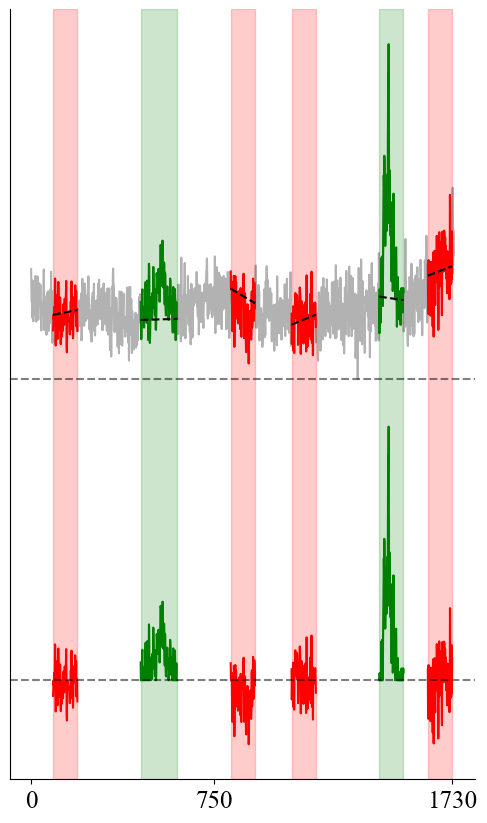

In [16]:
# Plot the noise and signal identification process


fig, ax = plt.subplots(figsize = (6, 10))
print(data_names[4])
spectrum = data[4][0] + 0.9
plt.plot(spectrum, color = "Black", alpha = 0.3)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

noise = []
signal = []

for region in noise_regions:

    ax.plot(region, spectrum[region], color = "Red")
    ax.plot((region[0], region[-1]), (np.median(spectrum[region[:8]]), np.median(spectrum[region[-8:]])), color = "black", linestyle = '--')
    ax.axvspan(region[0], region[-1], color = "red", alpha = 0.2)

    line = np.linspace(np.median(spectrum[region[:8]]), np.median(spectrum[region[-8:]]), len(region))

    ax.plot(region, spectrum[region] - line, color = "Red")
    noise = np.concatenate((noise, spectrum[region] - line))
                 
for region in signal_regions:
    l = int(len(region)/2)
    ax.axvspan(region[0], region[-1], color = "green", alpha = 0.2)
    
    ax.plot(region, spectrum[region], color = "Green")
    ax.plot((region[0], region[-1]), (np.median(spectrum[region[:8]]), np.median(spectrum[region[-8:]])), color = "black", linestyle = '--')
    
    line = np.linspace(np.median(spectrum[region][:8]), np.median(spectrum[region][-8:]), len(region))

    ax.plot(region, np.clip(spectrum[region] - line, 0, None), color = "Green")
    signal = np.concatenate(( signal, spectrum[region] - line))

signal = np.ravel(signal)
noise = np.ravel(noise)
ax.set_xticks([0, 750, 1730])

plt.axhline(y = np.min(spectrum), color = 'black', linestyle = '--', alpha = 0.5) 
plt.axhline(y = 0, color = 'black', linestyle = '--', alpha = 0.5) 

plt.savefig(img_path + "SignalNoisePreparation.pdf", format="pdf", dpi=1200, bbox_inches = "tight")
plt.show()


In [17]:
ensemble_preds = {}
standard_preds = {}

ensemble_components = {}
standard_components = {}

# Extract the noise from the spectra using our models
for d, n in zip(data, data_names):
    print(n) # Print the data name and exposure time info

        # Get the predictions
    ensemble_comp = ensemble_model.predict(np.expand_dims(d, -1))
    standard_comp = standard_model.predict(np.expand_dims(d, -1))
    
        # Add predictions to a dictionary
    ensemble_preds[n] = ensemble_comp[2]
    standard_preds[n] = standard_comp[2]

    ensemble_components[n] = ensemble_comp
    standard_components[n] = standard_comp

    


HF2600exp0.005s25um.h5
197/197 [==============================] - 15s 74ms/step
HF2600exp0.01s25um.h5
197/197 [==============================] - 14s 73ms/step
HF2600exp0.05s25um.h5
197/197 [==============================] - 14s 73ms/step
HF2600exp0.1s25um.h5
197/197 [==============================] - 14s 73ms/step
HF2600exp0.25s25um.h5
197/197 [==============================] - 14s 72ms/step
HF2600exp0.5s25um.h5
197/197 [==============================] - 14s 73ms/step
HF2600exp1s25um.h5
197/197 [==============================] - 14s 73ms/step
HF2600exp2s.h5
197/197 [==============================] - 14s 73ms/step
HF2600exp5s.h5
197/197 [==============================] - 14s 73ms/step


In [18]:
casc_preds = {}
casc_bl = {}
casc_peaks = {}
for d, n in zip(data, data_names):
    print(n)
        
    dn_1 = d
    
        # Normalization
    maxim = np.max(dn_1, axis = 1)
    minim = np.min(dn_1, axis = 1)
    dn_1 = (dn_1 - np.expand_dims(minim, -1)) / np.expand_dims(maxim - minim, -1)
        
        # Model is designed for spectrum length 1024, split the spectrum in half 
    pred_1 = np.squeeze(cascade.predict(np.expand_dims(dn_1[:, :1024]* 1000, -1)))
    pred_2 = np.squeeze(cascade.predict(np.expand_dims(dn_1[:, -1024 :]* 1000, -1)))

    peak_1 = pred_1[1]/1000
    bl_1 = dn_1[:, :1024] - pred_1[0]/1000

    peak_2 = pred_2[1]/1000
    bl_2 = dn_1[:, -1024 :] - pred_2[0]/1000
    
    noise_1 = dn_1[:, :1024] - peak_1 - bl_1
    noise_2 = dn_1[:, -1024:] - peak_2 - bl_2
    
        #Join the predictions in the middle
    noise = np.hstack((noise_1[:, :1738 - 1024], noise_2))
        
    casc_preds[n] = noise
    casc_bl[n] = np.hstack((bl_1[:, :1738 - 1024], bl_2))
    casc_peaks[n] = np.hstack((peak_1[:, :1738 - 1024], peak_2))

HF2600exp0.005s25um.h5
197/197 [==============================] - 17s 85ms/step
HF2600exp0.01s25um.h5
197/197 [==============================] - 17s 85ms/step
HF2600exp0.05s25um.h5
197/197 [==============================] - 17s 85ms/step
HF2600exp0.1s25um.h5
197/197 [==============================] - 17s 85ms/step
HF2600exp0.25s25um.h5
197/197 [==============================] - 17s 85ms/step
HF2600exp0.5s25um.h5
197/197 [==============================] - 17s 85ms/step
HF2600exp1s25um.h5
197/197 [==============================] - 17s 84ms/step
HF2600exp2s.h5
197/197 [==============================] - 17s 84ms/step
HF2600exp5s.h5
197/197 [==============================] - 17s 85ms/step


In [19]:
barton_preds = {}
for d, n in zip(data, data_names):
    print(n)
        
    dn_1 = d
    
        # Normalization
    maxim = np.max(dn_1, axis = 1)
    minim = np.min(dn_1, axis = 1)
    dn_1 = (dn_1 - np.expand_dims(minim, -1)) / np.expand_dims(maxim - minim, -1) * 4000

    barton_data = np.squeeze(dn_1).reshape(len(dn_1), len(dn_1[0]), 1, 1)
    pred_1 = np.squeeze(barton_model.predict(barton_data[:, :600, :1, :1]))
    pred_2 = np.squeeze(barton_model.predict(barton_data[:, 600 : 1200]))
    pred_3 = np.squeeze(barton_model.predict(barton_data[:, 1738 - 600 : 1738]))
    
    noise_1 = dn_1[:, :600] - pred_1
    noise_2 = dn_1[:, 600:1200] - pred_2
    noise_3 = dn_1[:, 1738 - 600 : 1738] - pred_3
    
        #Join the predictions in the middle
    noise = np.hstack((noise_1, noise_2, noise_3[:, 600*3 - 1738:]))
        
    barton_preds[n] = noise/4000

HF2600exp0.005s25um.h5
197/197 [==============================] - 1s 5ms/step
HF2600exp0.01s25um.h5
197/197 [==============================] - 1s 5ms/step
HF2600exp0.05s25um.h5
197/197 [==============================] - 1s 5ms/step
HF2600exp0.1s25um.h5
197/197 [==============================] - 1s 5ms/step
HF2600exp0.25s25um.h5
197/197 [==============================] - 1s 5ms/step
HF2600exp0.5s25um.h5
197/197 [==============================] - 1s 5ms/step
HF2600exp1s25um.h5
197/197 [==============================] - 1s 5ms/step
HF2600exp2s.h5
197/197 [==============================] - 1s 5ms/step
HF2600exp5s.h5
197/197 [==============================] - 1s 5ms/step


In [20]:
# Get the Savgol results

savgol_preds = {}
for d, n in zip(data, data_names):
    
    dn = d
    
        # Normalization
    maxim = np.max(dn, axis = 1)
    minim = np.min(dn, axis = 1)
    dn = (dn - np.expand_dims(minim, -1)) / np.expand_dims(maxim - minim, -1)
    
    savgol_clean = savgol_filter(dn, 5, 2, axis = 1) # Denoise with savgol
    noise = (dn - savgol_clean) # Get the noise that was removed
    
    savgol_preds[n] = noise

In [21]:
# SNR metrics
y_labels = []


for y in  data_names:
    y_labels.append(y[9: y.index("s")])

SNR_metrics = {}
    
for en, n in enumerate(np.flip(data_names)):
    dn = np.copy(data[-(en+1)])
        
    maxim = np.max(dn, axis = 1)
    minim = np.min(dn, axis = 1)
        # Normalize the spectrum such that maximum is 1, minimum is 0
    dn = (dn - np.expand_dims(minim, -1))/(np.expand_dims(maxim, -1) - np.expand_dims(minim, -1))

    
    noises = []
    for region in noise_regions:
            # Get noise signal from region
        noise = dn[:, region] 

            # Straighten the noise vector
            # Interpolate a line that goes through the noise vector, from the center of the left to the center of the right end.
        difference = np.linspace(np.median(noise[:, 0:8], axis = 1), np.median(noise[:, -8:], axis = 1), len(region))

        noise = (noise.T - difference).T
        noises.append(noise)

    signals = []
    for region in signal_regions:
            
            # Get the signal
        signal = dn[:, region]


        # Remove background influence on peak signal
        difference = np.linspace(np.min(signal[:, 0:8], axis = 1), np.min(signal[:, -8:], axis = 1), len(region))
        signal = (signal.T - difference).T


        signal = signal - np.expand_dims(np.min(signal, axis=1), 1)
        signals.append(signal)
        
    noises = np.concatenate(noises, axis = 1)
    signals = np.concatenate(signals, axis = 1)


    # Insert predictions here
    preds = [ensemble_preds, standard_preds, casc_preds, barton_preds, savgol_preds]
        
    stripped_preds = []
    for ix, p in enumerate(preds):
            # Add list for the predictions
        stripped_preds.append([])

            # go through the noise regions
        for region in noise_regions:
            
            pred_n = p[n][:, region]
            stripped_preds[-1].append(pred_n)

            # Concatenate the predictions
        stripped_preds[-1] = np.concatenate(stripped_preds[-1], axis = 1)
                
            
    SNR_metrics[n] = []
    for i in range(len(signal)):
            
        SNR_metrics[n].append ([
            SNR(signals[i], noises[i], stripped_preds[0][i]), # Ensemble
            SNR(signals[i], noises[i], stripped_preds[1][i]), # Standard
            SNR(signals[i], noises[i], stripped_preds[2][i]), # Cascaded
            SNR(signals[i], noises[i], stripped_preds[3][i]), # Barton
            SNR(signals[i], noises[i], stripped_preds[4][i]), # Savgol
            SNR(signals[i], noises[i], 0) # Raw
        ])

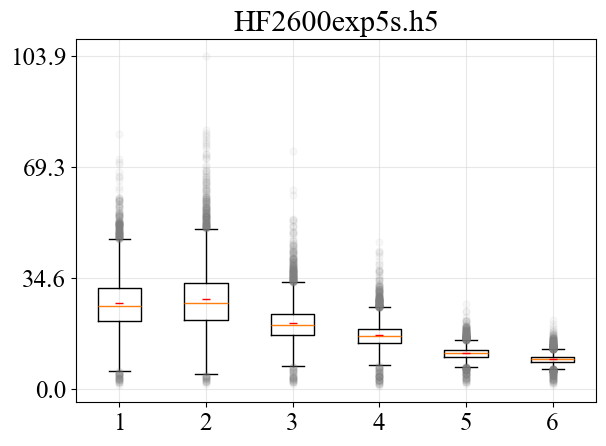

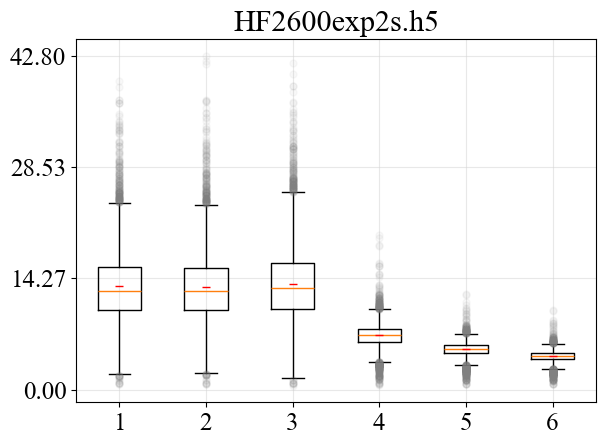

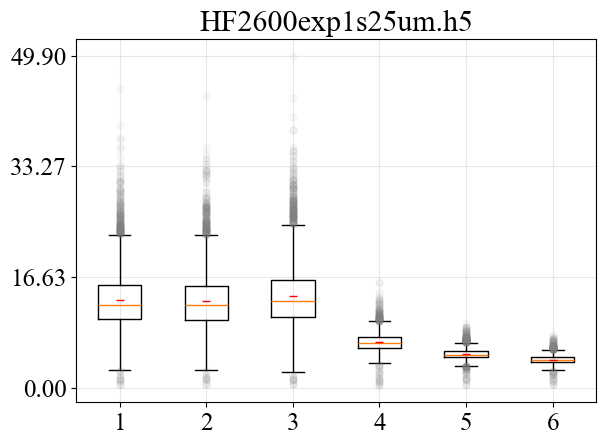

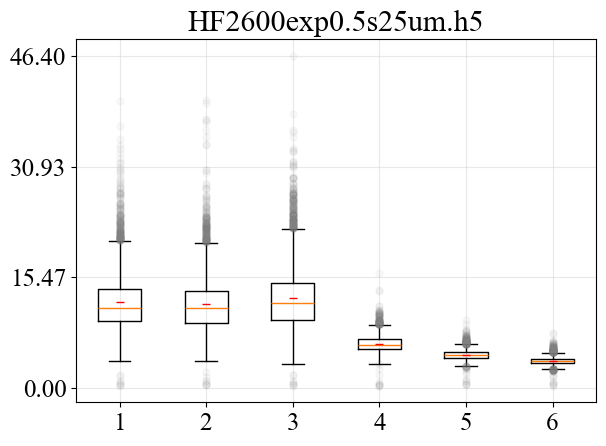

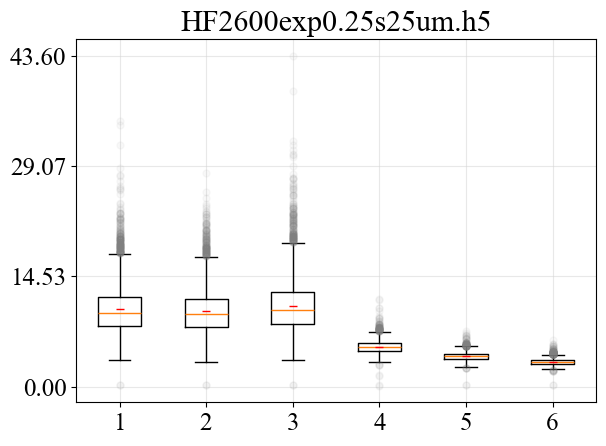

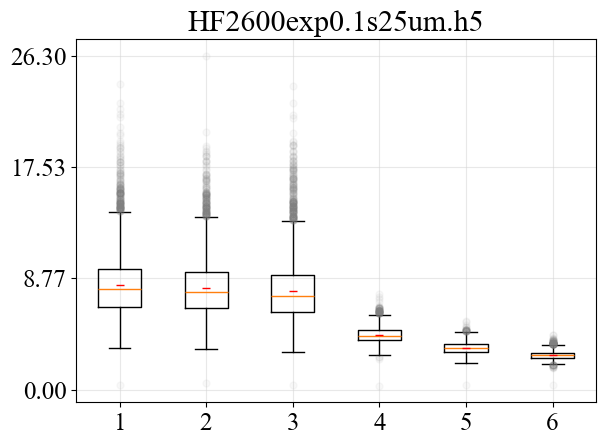

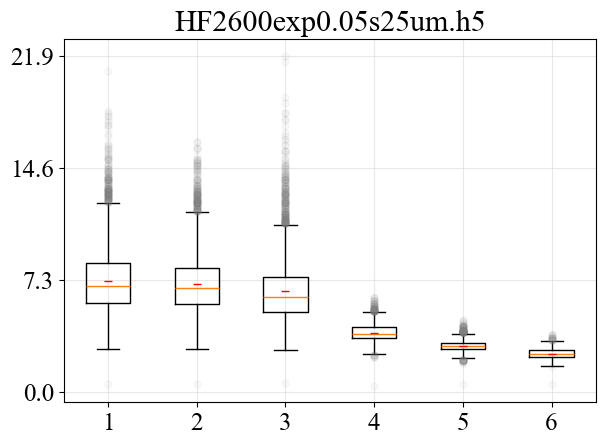

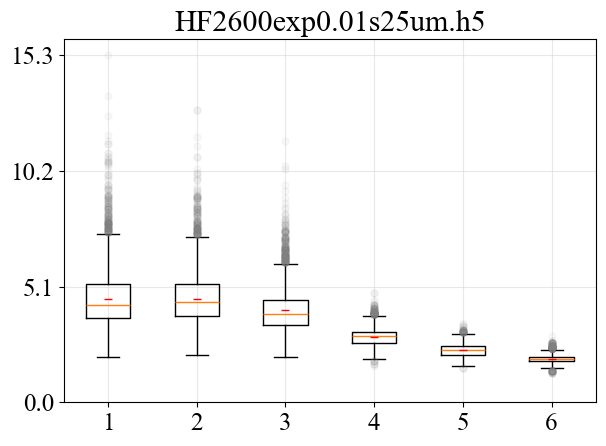

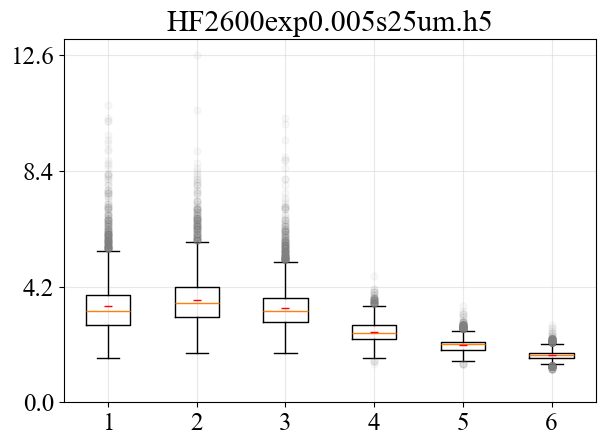

In [22]:
model_names = ["Ensemble", "Standard", "Kazemzadeh et al.", "Savitzky-Golay", "Raw"]
flier_props = dict(marker='o', markerfacecolor='gray', alpha = 0.05, markersize=5,
                  linestyle='none', markeredgecolor="gray")
mean_props = {"marker": "_", 'markerfacecolor': "Red", 'markeredgecolor': "Red"}

for k in SNR_metrics.keys():
    
    plt.boxplot(np.array(SNR_metrics[k]),
                #labels = model_names,
                  showmeans=True, 
                  flierprops = flier_props,
                  meanprops= mean_props,
               )
    plt.title(k)
    num_ticks = 4
    max_ = np.max(SNR_metrics[k])
    ticks = np.linspace(0, max_, num_ticks)
    plt.yticks(ticks)
    #plt.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    plt.tight_layout() # Improves spacing between plots to prevent overlap
    plt.show()

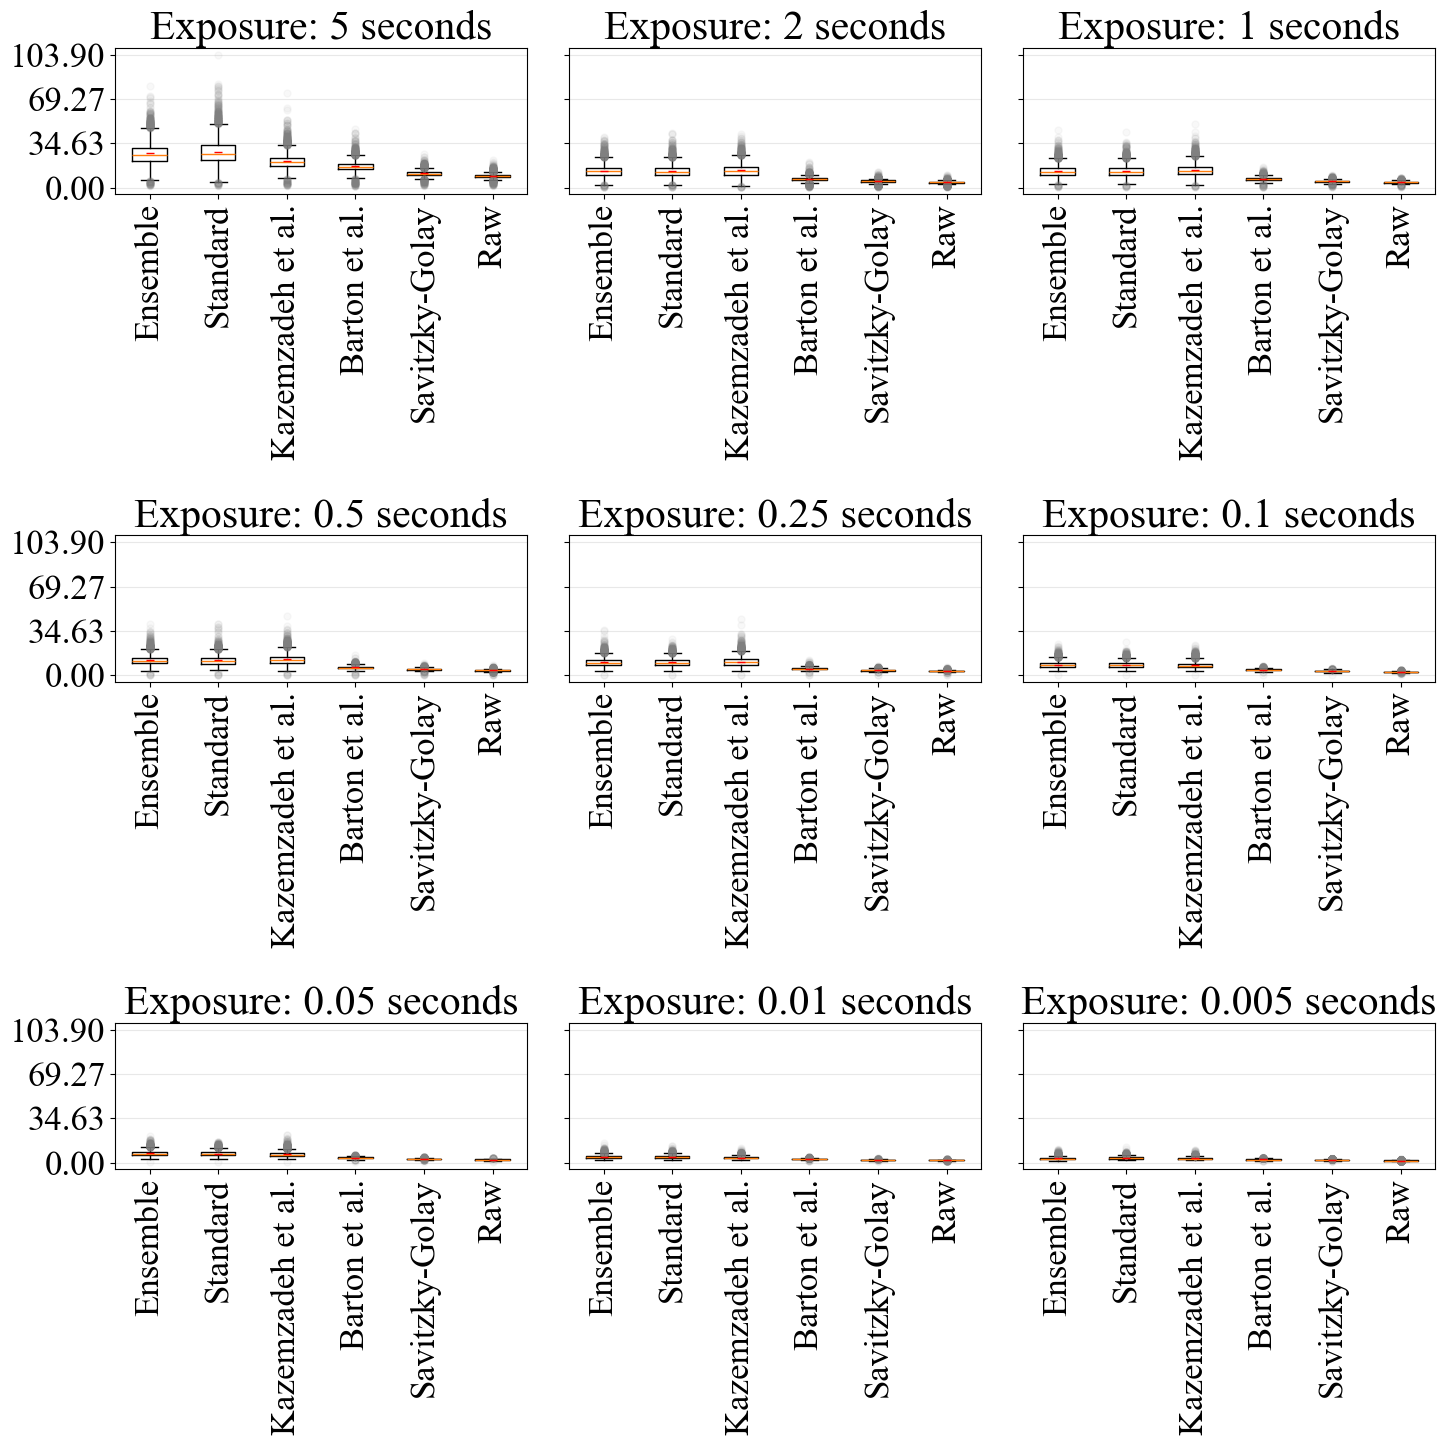

In [23]:
plt.rcParams.update({'font.size': 25})
plt.rcParams["font.family"] = "Times New Roman"
model_names = ["Ensemble", "Standard", "Kazemzadeh et al.", "Barton et al.", "Savitzky-Golay", "Raw"]

fig, ax = plt.subplots(nrows=3, ncols =3, figsize = (15, 15), sharey = True)

x_counter = 0
y_counter = 0
for d, n in zip(reversed(data), reversed(data_names)):
    x = x_counter
    y = y_counter
    
    # Boxplots for SNR
    flier_props = dict(marker='o', markerfacecolor='gray', alpha = 0.05, markersize=5,
                  linestyle='none', markeredgecolor="gray")
    mean_props = {"marker": "_", 'markerfacecolor': "Red", 'markeredgecolor': "Red"}

    ax[y][x].boxplot(np.array(SNR_metrics[n]),
                  #labels = model_names,
                  showmeans=True, 
                  flierprops = flier_props,
                  meanprops= mean_props,
               #showfliers = False
                 )
    
    ax[y][x].set_title("Exposure: " +str(n[9:n.index("s")]) + " seconds")
    max_ = np.max(SNR_metrics[data_names[-1]])
    min_ = 0
    num_ticks = 4
    ticks = np.linspace(min_, max_, num_ticks)
    ax[y][x].set_yticks(ticks)
    ax[y][x].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[y][x].yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    ax[y][x].set_xticklabels(model_names, rotation = 90)
    fig.tight_layout() # Improves spacing between plots to prevent overlap


    x_counter += 1
    if x_counter == 3:
        y_counter += 1
        x_counter = 0

plt.savefig(img_path + "Boxplots.pdf", format="pdf", dpi=1200, bbox_inches = "tight")
plt.show()

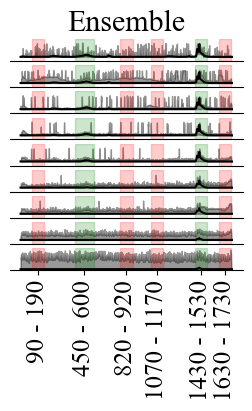

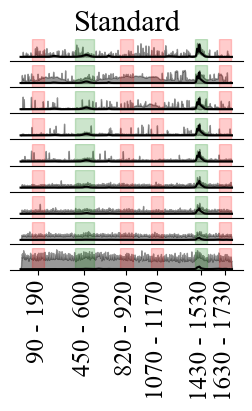

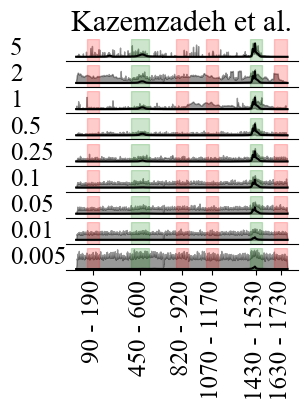

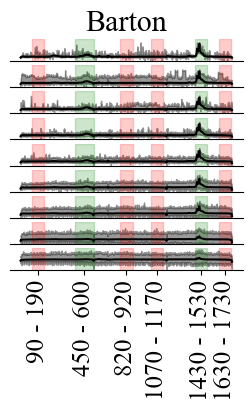

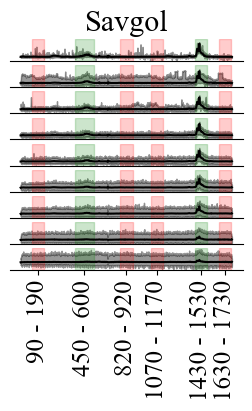

In [24]:
y_labels = []
for y in data_names:
    y_labels.append(y[9: y.index("s")])


plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"

model_names = ["Ensemble", "Standard", "Kazemzadeh et al.", "Barton", "Savgol"]
name_ind = -1
for exposure_preds in [ensemble_preds, standard_preds, casc_preds, barton_preds, savgol_preds]:
    name_ind += 1
    fig, axs = plt.subplots(len(data_names), figsize = (3, 3), sharex=False, sharey=False)
    axs[0].set_title(model_names[name_ind])
    
    for en, n in enumerate(np.flip(data_names)):
        dn = np.squeeze(np.copy(data[-(en+1)]))
        preds = exposure_preds[n]

        if model_names[name_ind] == "Ensemble":
            denoised = ensemble_components[n][-1]
        elif model_names[name_ind] == "Standard":
            denoised = standard_components[n][-1]
        elif model_names[name_ind] == "Kazemzadeh et al.":
            denoised = casc_peaks[n]
        else:
            denoised = dn - np.array(preds) - casc_bl[n]

        # Plot the percentiles on each frequency
        axs[en].fill_between(np.arange(1738), np.percentile(denoised, 0, axis = 0), np.percentile(denoised, 100, axis = 0), alpha = 0.4,
                             color = "Black")
        
        # Plot the mean vector of the data class
        axs[en].plot(np.median(denoised, axis = 0), color = "Black")
    
        for region in noise_regions:
            axs[en].axvspan(region[0], region[-1], color = "red", alpha = 0.2)
    
        for region in signal_regions:
            axs[en].axvspan(region[0], region[-1], color = "green", alpha = 0.2)
    
        
        #axs[en].set_ylabel("Time: " + np.flip(y_labels)[en] + "\nSNR: " +str(raw_snr), rotation=0, loc='bottom', labelpad=65)
        #axs[en].set_ylabel("Time: " + np.flip(y_labels)[en], rotation=0, loc='bottom', labelpad=30)
        if model_names[name_ind] == "Kazemzadeh et al.":
            axs[en].set_ylabel(np.flip(y_labels)[en], rotation=0, loc='bottom', labelpad=40)
        axs[en].set_xticks([])
        axs[en].set_yticks([])
        axs[en].set_ylim(-0.3, 1.3)
        axs[en].spines['left'].set_visible(False)
        axs[en].spines['right'].set_visible(False)
        axs[en].spines['top'].set_visible(False)
        #leg = axs[en].legend(["SNR: " +str(raw_snr)], loc = "upper right", bbox_to_anchor=(1.3, 1.3), fontsize = 8, frameon=False)
        #leg.get_frame().set_linewidth(0.0)
        
    plt.autoscale() 
    #plt.xticks([0, 750, 1500])
    x_ticks = np.ravel([np.mean([np.min(reg), np.max(reg)]) for reg in joined_regions])
    x_labels = [str(np.min(reg)) + " - " + str(np.max(reg)) for reg in joined_regions]
    plt.xticks(x_ticks, x_labels, rotation = 90)
    plt.savefig(img_path + model_names[name_ind] + "Distro.png", format="png", dpi=1200, bbox_inches = "tight")
    plt.show()